In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip

%matplotlib inline
from IPython.display import HTML


def corners_unwarp(cb_image, nx, ny, mtx, dist):
    undistorted = cv2.undistort(cb_image, mtx, dist, None, mtx)
    gray = cv2.cvtColor(undistorted, cv2.COLOR_RGB2GRAY)
    image_w, image_h = gray.shape[1], gray.shape[0]

    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    if not ret:
        print('WARNING: Failed to detect corners for image {} with nx {} and ny {}'.format(image_fname, nx, ny))
        return None, None

    cv2.drawChessboardCorners(undistorted, (nx, ny), corners, ret)

    src_tl = corners[0][0]
    src_tr = corners[nx-1][0]
    src_br = corners[-1][0]
    src_bl = corners[-nx][0]

    offset = 200
    dst_tl = [offset, offset]
    dst_tr = [image_w-offset, offset]
    dst_br = [image_w-offset, image_h-offset]
    dst_bl = [offset, image_h-offset]

    src = np.float32([src_tl, src_tr, src_br, src_bl])
    dst = np.float32([dst_tl, dst_tr, dst_br, dst_bl])

    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(undistorted, M, gray.shape[::-1], flags=cv2.INTER_LINEAR)

    return warped, M


class LaneLine():

    def __init__(self):
        # Calculate calibration parameters
        cb_fnames = glob.glob('camera_cal/calibration*.jpg')
        nx, ny = 9, 6
        self.img_w, self.img_h = 1280, 720
        self.mtx, self.dist = self.calibrate(cb_fnames, nx, ny, self.img_w, self.img_h)

        # Calculate perspective transformation matrix
        dst_offset = 300
        src_bl, src_br, src_tl, src_tr = [190,720], [1090,720], [600,440], [680,440]
        dst_bl, dst_br, dst_tl, dst_tr = [dst_offset,self.img_h], [self.img_w-dst_offset,self.img_h], [dst_offset,0], [self.img_w-dst_offset,0]
        psp_src = np.float32([src_tl, src_tr, src_br, src_bl])
        psp_dst = np.float32([dst_tl, dst_tr, dst_br, dst_bl])
        self.M = cv2.getPerspectiveTransform(psp_src, psp_dst)
        self.Minv = cv2.getPerspectiveTransform(psp_dst, psp_src)

        self.l_fit = None
        self.r_fit = None


    def calibrate(self, fnames, nx, ny, img_w, img_h, verbose=True):
        objpoints = []
        imgpoints = []

        objp = np.zeros((ny * nx, 3), np.float32)
        objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

        if verbose:
            print('Calibration started...')

        for fname in fnames:
            if verbose:
                print('Finding chesshboard in {}'.format(fname))
            img = mpimg.imread(fname)
            gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
            if ret:
                if verbose:
                    print('Found chessboard in {}'.format(fname))
                imgpoints.append(corners)
                objpoints.append(objp)

        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (img_w, img_h), None, None)
        if not ret:
            print('WARNING: Failed to calibrate camera')
            return None, None

        if verbose:
            print('Calibration succeeded...')

        return mtx, dist


    @classmethod
    def hls_thresh(self, img, chan=2, thresh=(0, 255)):
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        channel_s = hls[:,:,chan]
        binary = np.zeros_like(channel_s)
        binary[(channel_s > thresh[0]) & (channel_s <=thresh[1])] = 1
        return binary

    
    @classmethod
    def abs_thresh(self, img, ksize=3, thresh=(0,255), orient='x'):
        axis = 0 if orient == 'x' else 1
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        raw_sobel = cv2.Sobel(gray, cv2.CV_64F, 1-axis, axis, ksize=ksize)
        abs_sobel = np.absolute(raw_sobel)
        scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
        binary_output = np.zeros_like(scaled_sobel)
        binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
        return binary_output

    
    @classmethod
    def mag_thresh(self, img, ksize=3, thresh=(0,255)):
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=ksize)
        sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=ksize)
        mag_sobel = np.sqrt(np.square(sobel_x) + np.square(sobel_y))
        scaled_sobel = np.uint8(255 * mag_sobel / np.max(mag_sobel))
        binary_output = np.zeros_like(scaled_sobel)
        binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <=thresh[1])] = 1
        return binary_output


    @classmethod
    def dir_thresh(self, img, ksize=3, thresh=(0, np.pi/2)):
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        abs_sobel_x = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=ksize))
        abs_sobel_y = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=ksize))
        dir_sobel = np.arctan2(abs_sobel_y, abs_sobel_x)
        binary_output = np.zeros_like(dir_sobel)
        binary_output[(dir_sobel >= thresh[0]) & (dir_sobel <= thresh[1])] = 1
        return binary_output


    def find_fits(self, img, n_windows=9, margin=100, minpix=50, draw_overlay=True):

        # All non-zero pixel locations
        nonzero = img.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        # Indices found for pixels on lane lines
        l_lane_idxs = []
        r_lane_idxs = []

        l_fit = self.l_fit
        r_fit = self.r_fit

        # If we are passed in fits from last frame, then skip sliding window
        reuse_fits = not (l_fit is None or r_fit is None)

        if reuse_fits:
            l_lane_idxs = ((nonzerox > (l_fit[0]*(nonzeroy**2) + l_fit[1]*nonzeroy + l_fit[2] - margin)) & (nonzerox < (l_fit[0]*(nonzeroy**2) + l_fit[1]*nonzeroy + l_fit[2] + margin)))
            r_lane_idxs = ((nonzerox > (r_fit[0]*(nonzeroy**2) + r_fit[1]*nonzeroy + r_fit[2] - margin)) & (nonzerox < (r_fit[0]*(nonzeroy**2) + r_fit[1]*nonzeroy + r_fit[2] + margin)))
        else:
            # Histogram of bottom half of img
            histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
            # Left and right x-coord at the base, and window height
            midpoint = histogram.shape[0] // 2
            xl_base = np.argmax(histogram[:midpoint])
            xr_base = np.argmax(histogram[midpoint:]) + midpoint
            window_h = img.shape[0] // n_windows
            # Sliding window loop
            xl_current = xl_base
            xr_current = xr_base
            for window in range(n_windows):
                # Window boundaries
                win_y_lo = img.shape[0] - window_h * (window + 1)
                win_y_hi = img.shape[0] - window_h * window
                # Left lane window
                win_xl_lo = xl_current - margin
                win_xl_hi = xl_current + margin
                # Right lane window
                win_xr_lo = xr_current - margin
                win_xr_hi = xr_current + margin
                # Find non-zero pixels within window
                good_l_idxs = ((nonzeroy >= win_y_lo) & (nonzeroy < win_y_hi) & (nonzerox >= win_xl_lo) & (nonzerox < win_xl_hi)).nonzero()[0]
                good_r_idxs = ((nonzeroy >= win_y_lo) & (nonzeroy < win_y_hi) & (nonzerox >= win_xr_lo) & (nonzerox < win_xr_hi)).nonzero()[0]
                # Append to list of found indices
                l_lane_idxs.append(good_l_idxs)
                r_lane_idxs.append(good_r_idxs)
                # If found more than minpix pixels, recenter next window on their mean position
                if len(good_l_idxs) > minpix:
                    xl_current = np.int(np.mean(nonzerox[good_l_idxs]))
                if len(good_r_idxs) > minpix:
                    xr_current = np.int(np.mean(nonzerox[good_r_idxs]))
            # Flatten
            l_lane_idxs = np.concatenate(l_lane_idxs)
            r_lane_idxs = np.concatenate(r_lane_idxs)

        # Gather all pixel locations on lane lines
        lx = nonzerox[l_lane_idxs]
        ly = nonzeroy[l_lane_idxs]
        rx = nonzerox[r_lane_idxs]
        ry = nonzeroy[r_lane_idxs]

        # Fit polynomial for each lane
        new_l_fit = np.polyfit(ly, lx, 2)
        new_r_fit = np.polyfit(ry, rx, 2)

        self.l_fit = new_l_fit
        self.r_fit = new_r_fit

        # Output to be drawn
        out_img = np.dstack((img, img, img))*255

        if draw_overlay:
            # Draw fitted lane lines
            ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
            l_fit_x = new_l_fit[0] * ploty ** 2 + new_l_fit[1] * ploty + new_l_fit[2]
            r_fit_x = new_r_fit[0] * ploty ** 2 + new_r_fit[1] * ploty + new_r_fit[2]
            
            window_l_line = np.array([np.transpose(np.vstack([l_fit_x, ploty]))])
            window_r_line = np.array([np.transpose(np.vstack([r_fit_x, ploty]))])
            window_pts = np.hstack((window_l_line, np.fliplr(window_r_line)))

            window_img = np.zeros_like(out_img)
            cv2.fillPoly(window_img, np.int_([window_pts]), (0,255,0))
            #out_img = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
            out_img = window_img
        else:
            pass

        # Now calculate curvature
        y_eval = np.max(ploty)
        
        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 60. / 720 # meters per pixel in y dimension
        xm_per_pix = 3.7 / 700 # meters per pixel in x dimension
        
        l_fit_cr = np.polyfit(ly * ym_per_pix, lx * xm_per_pix, 2)
        r_fit_cr = np.polyfit(ry * ym_per_pix, rx * xm_per_pix, 2)
        
        l_curverad = ((1 + (2*l_fit_cr[0]*y_eval*ym_per_pix + l_fit_cr[1])**2)**1.5) / np.absolute(2*l_fit_cr[0])
        r_curverad = ((1 + (2*r_fit_cr[0]*y_eval*ym_per_pix + r_fit_cr[1])**2)**1.5) / np.absolute(2*r_fit_cr[0])
        
        curvature = (l_curverad + r_curverad) / 2
        
        # Now calculate position offset
        unwarped = self.perspective(window_img, True)
        pts = np.argwhere(unwarped[:,:,1])
        center = img.shape[1] / 2
        pos_l = np.min(pts[(pts[:,1] < center) & (pts[:,0] > 700)][:,1])
        pos_r = np.max(pts[(pts[:,1] > center) & (pts[:,0] > 700)][:,1])
        pos = (pos_l + pos_r)/2
        offset = (center - pos) * xm_per_pix
        
        return out_img, curvature, offset
        

    def undistort(self, img):
        return cv2.undistort(img, self.mtx, self.dist, None, self.mtx)


    def perspective(self, img, inverse=False):
        m = self.Minv if inverse else self.M
        return cv2.warpPerspective(img, m, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)


    def thresh_img(self, img):
        img_abs = self.abs_thresh(img, thresh=(20,100))
        img_hls = self.hls_thresh(img, thresh=(90,255))
        out = np.zeros_like(img_abs)
        out[(img_abs > 0) | (img_hls > 0)] = 1
        return out


    def process_img(self, img):
        out_img, curvature, offset = self.find_fits(self.perspective(self.thresh_img(self.undistort(img))))
        out_img = self.perspective(out_img, True)
        out_img = cv2.addWeighted(img, 1, out_img, 0.7, 0)
        curvature_str = "Curvature: {}m".format(int(curvature))
        posoffset_str = "Offset: {}m to the {}".format(round(abs(offset), 3), "left" if offset < 0 else "right")
        out_img = cv2.putText(out_img, curvature_str, (100, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, 255)
        out_img = cv2.putText(out_img, posoffset_str, (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 1, 255)
        return out_img


    def process_clip(self, video):
        clip = VideoFileClip(video)
        new_clip = clip.fl_image(self.process_img)
        return new_clip

    
ll = LaneLine()

Calibration started...
Finding chesshboard in camera_cal/calibration1.jpg
Finding chesshboard in camera_cal/calibration10.jpg
Found chessboard in camera_cal/calibration10.jpg
Finding chesshboard in camera_cal/calibration11.jpg
Found chessboard in camera_cal/calibration11.jpg
Finding chesshboard in camera_cal/calibration12.jpg
Found chessboard in camera_cal/calibration12.jpg
Finding chesshboard in camera_cal/calibration13.jpg
Found chessboard in camera_cal/calibration13.jpg
Finding chesshboard in camera_cal/calibration14.jpg
Found chessboard in camera_cal/calibration14.jpg
Finding chesshboard in camera_cal/calibration15.jpg
Found chessboard in camera_cal/calibration15.jpg
Finding chesshboard in camera_cal/calibration16.jpg
Found chessboard in camera_cal/calibration16.jpg
Finding chesshboard in camera_cal/calibration17.jpg
Found chessboard in camera_cal/calibration17.jpg
Finding chesshboard in camera_cal/calibration18.jpg
Found chessboard in camera_cal/calibration18.jpg
Finding chesshboa

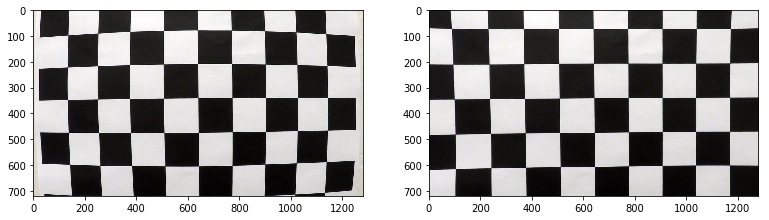

In [2]:
# Test calibration with chessboard image
orig = mpimg.imread('camera_cal/calibration1.jpg')
img = cv2.undistort(orig, ll.mtx, ll.dist, None, ll.mtx)
fig = plt.figure(figsize = (13,4))
plot = fig.add_subplot(1,2,1)
plot.imshow(orig)
plot = fig.add_subplot(1,2,2)
plot.imshow(img)
fig.savefig('output_images/calibration1_undistorted.jpg')

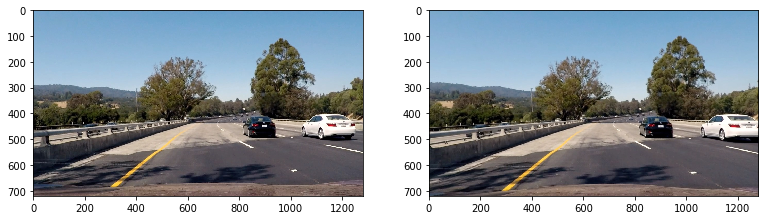

In [3]:
# Test calibration with test image
orig = mpimg.imread('test_images/test4.jpg')
img = cv2.undistort(orig, ll.mtx, ll.dist, None, ll.mtx)
fig = plt.figure(figsize = (13,4))
plot = fig.add_subplot(1,2,1)
plot.imshow(orig)
plot = fig.add_subplot(1,2,2)
plot.imshow(img)
plt.savefig('output_images/test4_undistorted.jpg')

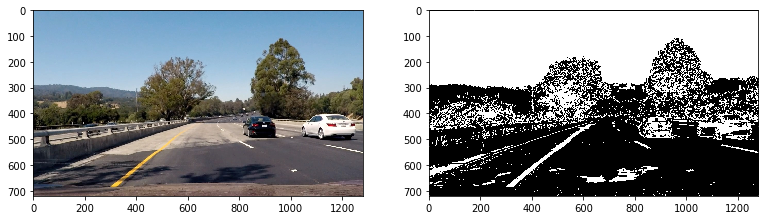

In [4]:
# Test thresholding image
orig = mpimg.imread('test_images/test4.jpg')
img = ll.thresh_img(orig)
fig = plt.figure(figsize = (13,4))
plot = fig.add_subplot(1,2,1)
plot.imshow(orig)
plot = fig.add_subplot(1,2,2)
plot.imshow(img, cmap='gray')
plt.savefig('output_images/test4_thresholded.jpg')

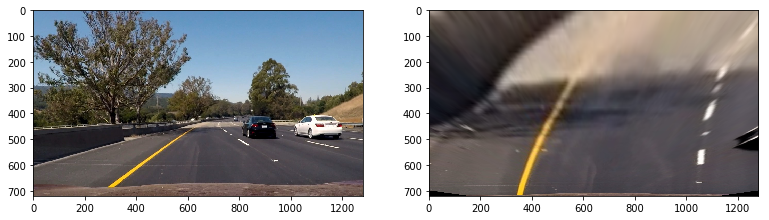

In [5]:
# Test perspective transformation
orig = mpimg.imread('test_images/test6.jpg')
img = ll.perspective(ll.undistort(orig))
fig = plt.figure(figsize = (13,4))
plot = fig.add_subplot(1,2,1)
plot.imshow(orig)
plot = fig.add_subplot(1,2,2)
plot.imshow(img)
plt.savefig('output_images/test6_perspective.jpg')

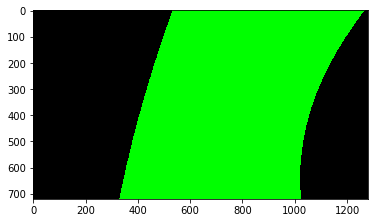

In [6]:
# Test thresholding and line fitting
img, _, _ = ll.find_fits(ll.perspective(ll.thresh_img(ll.undistort(mpimg.imread('test_images/test1.jpg')))))
plt.imshow(img)
plt.savefig('output_images/test1_fit.jpg')

In [7]:
ll = LaneLine()
out = ll.process_clip('project_video.mp4')
%time out.write_videofile('output.mp4', audio=False)

Calibration started...
Finding chesshboard in camera_cal/calibration1.jpg
Finding chesshboard in camera_cal/calibration10.jpg
Found chessboard in camera_cal/calibration10.jpg
Finding chesshboard in camera_cal/calibration11.jpg
Found chessboard in camera_cal/calibration11.jpg
Finding chesshboard in camera_cal/calibration12.jpg
Found chessboard in camera_cal/calibration12.jpg
Finding chesshboard in camera_cal/calibration13.jpg
Found chessboard in camera_cal/calibration13.jpg
Finding chesshboard in camera_cal/calibration14.jpg
Found chessboard in camera_cal/calibration14.jpg
Finding chesshboard in camera_cal/calibration15.jpg
Found chessboard in camera_cal/calibration15.jpg
Finding chesshboard in camera_cal/calibration16.jpg
Found chessboard in camera_cal/calibration16.jpg
Finding chesshboard in camera_cal/calibration17.jpg
Found chessboard in camera_cal/calibration17.jpg
Finding chesshboard in camera_cal/calibration18.jpg
Found chessboard in camera_cal/calibration18.jpg
Finding chesshboa

100%|█████████▉| 1260/1261 [02:22<00:00,  8.33it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

CPU times: user 3min 28s, sys: 14.7 s, total: 3min 42s
Wall time: 2min 23s


In [8]:
HTML("""
<video width="640" height="480" controls>
  <source src="output.mp4" type="video/mp4">
</video>
""")

In [9]:
HTML("""
<video width="640" height="480" controls>
  <source src="project_video.mp4" type="video/mp4">
</video>
""")